<center>

# `ProxNest` - __Denoising Example__
---

Suppose we collect complete observations $y \in \mathbb{R}^N$ of some image $x \in \mathbb{R}^N$ under a trivial forward model $\Phi = \mathbb{I}$. Suppose further that our observational instrument introduces some aleoteric uncertainty which can be adequately modelled by a univariate Gaussian $n = \mathcal{N}(0, \sigma) \in \mathbb{R}^N$. In this case our measurement equation is given by $$y = x + n.$$

Under these conditions the inverse problem of infering $x$ given $y$ is degenerate and thus breaks [Hadamards](https://en.wikipedia.org/wiki/Well-posed_problem) second condition: the solution is not unique and thus the inverse problem is ill-posed. Given that inferences of $x$ are degenerate it naturally makes more sense to consider the probability distribution of possible solutions; the posterior distribution. Here we use **proximal nested sampling** ([Cai *et al* 2022](https://arxiv.org/abs/2106.03646)), which allows us to sample from this posterior distribution, recovering both an estimate of $x$ and the plausibility of this estimate. Moreover, as this is a nested sampling algorithm we automatically recover the Bayesian evidence, which naturally allows us to carry out model comparison, through which one can *e.g.* determine which forward models $\Phi$ are favoured by the data, or calibrate hyper-parameters of the problem such as $\sigma$ and regularisation parameters $\lambda$.

In this notebook, we compare the use of a data-driven prior (DnCNN network) and a handcrafted prior (sparsity on a wavelet basis).

In [1]:
import sys
import time
import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import ProxNest as pxn
import ProxNest.utils as utils
import ProxNest.sampling as sampling
import ProxNest.optimisations as optimisations
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tick

plt.rcParams["font.family"] = "serif"



### Load an image and simulate some observations

In [2]:
# Load Image
dim = 64
ground_truth = np.load('/disk/xray0/tl3/project-nested-diffusion/proxnest/data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

### Construct linear operators and mock simulated observations for our stated problem

In [3]:
np.random.seed(0)

# A simple identity forward model
phi = operators.sensing_operators.Identity()

# A wavelet dictionary in which we can promote sparsity
psi = operators.wavelet_operators.db_wavelets(["db6"], 2, (dim, dim))

In [4]:
# Define noise parameters
ISNR = 15
sigma = np.sqrt(np.mean(np.abs(ground_truth)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, ground_truth.shape)

# Simulate mock noisy observations
y = phi.dir_op(ground_truth) + n

### Define all necessary parameters and posterior lambda functions

In [5]:
# Regularisation parameter
alpha = 0.005

# Sampling parameters
delta_step_DnCNN = 1e-7
lamb_DnCNN = 5 * 1e-7
gamma_DnCNN = alpha * sigma**2



In [6]:
# Regularisation parameter
WAV_reg_param = 2e4 

# Sampling parameters
delta_step_WAV = 1e-7
lamb_WAV = 5. * delta_step_WAV
gamma_WAV = 5. * delta_step_WAV





In [7]:
# Parameter dictionary associated with optimisation problem of resampling from the prior subject to the likelihood iso-ball
params_WAV = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-10,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = False,                 # Positivity flag
     reality = False                  # Reality flag
)

params_DnCNN = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-10,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = False,                 # Positivity flag
     reality = False                  # Reality flag
)

# Options dictionary associated with the overall sampling algorithm
options_DnCNN = utils.create_options_dict(
    samplesL = 1e2,                  # Number of live samples
    samplesD = 2.5e3,                # Number of discarded samples 
    thinning = 2e1,                  # Thinning factor (to mitigate correlations)
       delta = delta_step_DnCNN,     # Discretisation stepsize
       lamb = lamb_DnCNN,
        burn = 1e2,                  # Number of burn in samples
       sigma = sigma,                # Noise standard deviation of degraded image
       gamma = gamma_DnCNN,          # Gamma parameter of the prior term. Using noise variance
)

options_WAV = utils.create_options_dict(
    samplesL = 1e2,                   # Number of live samples
    samplesD = 2.5e3,                 # Number of discarded samples 
    thinning = 2e1,                   # Thinning factor (to mitigate correlations)
       delta = delta_step_WAV,        # Discretisation stepsize
       lamb = lamb_WAV,
        burn = 1e2,                   # Number of burn in samples
       sigma = sigma,                 # Noise standard deviation of degraded image
       gamma = gamma_WAV,             # Gamma parameter of the prior term. Using noise variance
)


In [8]:

# Lambda functions to evaluate cost function
LogLikeliL = lambda sol : - np.linalg.norm(y-phi.dir_op(sol), 'fro')**2/(2*sigma**2)

# Lambda function for L1-norm wavelet prior backprojection steps
proxH_WAV = lambda x, T : operators.proximal_operators.l1_projection(x, T, WAV_reg_param, Psi=psi)


# Lambda function for L2-ball likelihood projection during resampling
proxB_WAV = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_WAV)

# Lambda function for L2-ball likelihood projection during resampling
proxB_DnCNN = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_DnCNN)


In [9]:
# Saved dir of the model in SavedModel format
saved_model_path = '/disk/xray0/tl3/project-nested-diffusion/proxnest/papers/MaxEnt/networks/DnCNN/snr_15_model.pb'
# Load DnCNN denoiser prox
proxH_DnCNN = pxn.operators.learned_operators.prox_DnCNN(saved_model_path)


2023-10-31 18:07:01.872145: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 18:07:02.374118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 34439 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


### Select a starting position $X_0$ and execute the sampling method

In [10]:
# Create a 'dirty image' starting position
X0 = np.abs(phi.adj_op(np.copy(y)))


In [11]:
save_fig_dir = '../paper_figures/'
save_var_dir = '../paper_vars/'

save_prefix_WAV = 'denoising_WAV_delta_{:.1e}_lamb_{:.1e}_gamma_{:.1e}'.format(
    delta_step_WAV, lamb_WAV, gamma_WAV
)

save_prefix_DnCNN = 'denoising_DnCNN_delta_{:.1e}_lamb_{:.1e}_gamma_{:.1e}'.format(
    delta_step_DnCNN, lamb_DnCNN, gamma_DnCNN
)


# DnCNN

In [12]:
time_start = time.time()
# Perform proximal nested sampling
NS_BayEvi_DnCNN, NS_Trace_DnCNN = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_DnCNN, proxB_DnCNN, params_DnCNN, options_DnCNN
)
elapsed_time = time.time() - time_start
print('elapsed_time: ', elapsed_time)

ProxNest || Initialise:   0%|          | 0/200 [00:00<?, ?it/s]2023-10-31 18:07:04.158131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-10-31 18:07:04.833736: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
ProxNest || Initialise: 100%|██████████| 200/200 [00:03<00:00, 64.79it/s] 
ProxNest || Populate: 100%|██████████| 2098/2098 [00:03<00:00, 611.22it/s]
ProxNest || Sample: 100%|██████████| 2500/2500 [00:45<00:00, 54.92it/s]
ProxNest || Compute Weights: 100%|██████████| 2500/2500 [00:00<00:00, 632739.56it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 2498/2498 [00:00<00:00, 1160541.80it/s]
ProxNest || Estimate Variance: 100%|██████████| 2500/2500 [00:00<00:00, 321432.16it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 2500/2500 [00:00<00:00, 347774.87it/s]

elapsed_time:  52.09523272514343


In [13]:
print(NS_BayEvi_DnCNN)


[-1.08379125e+03  3.56730146e-01]


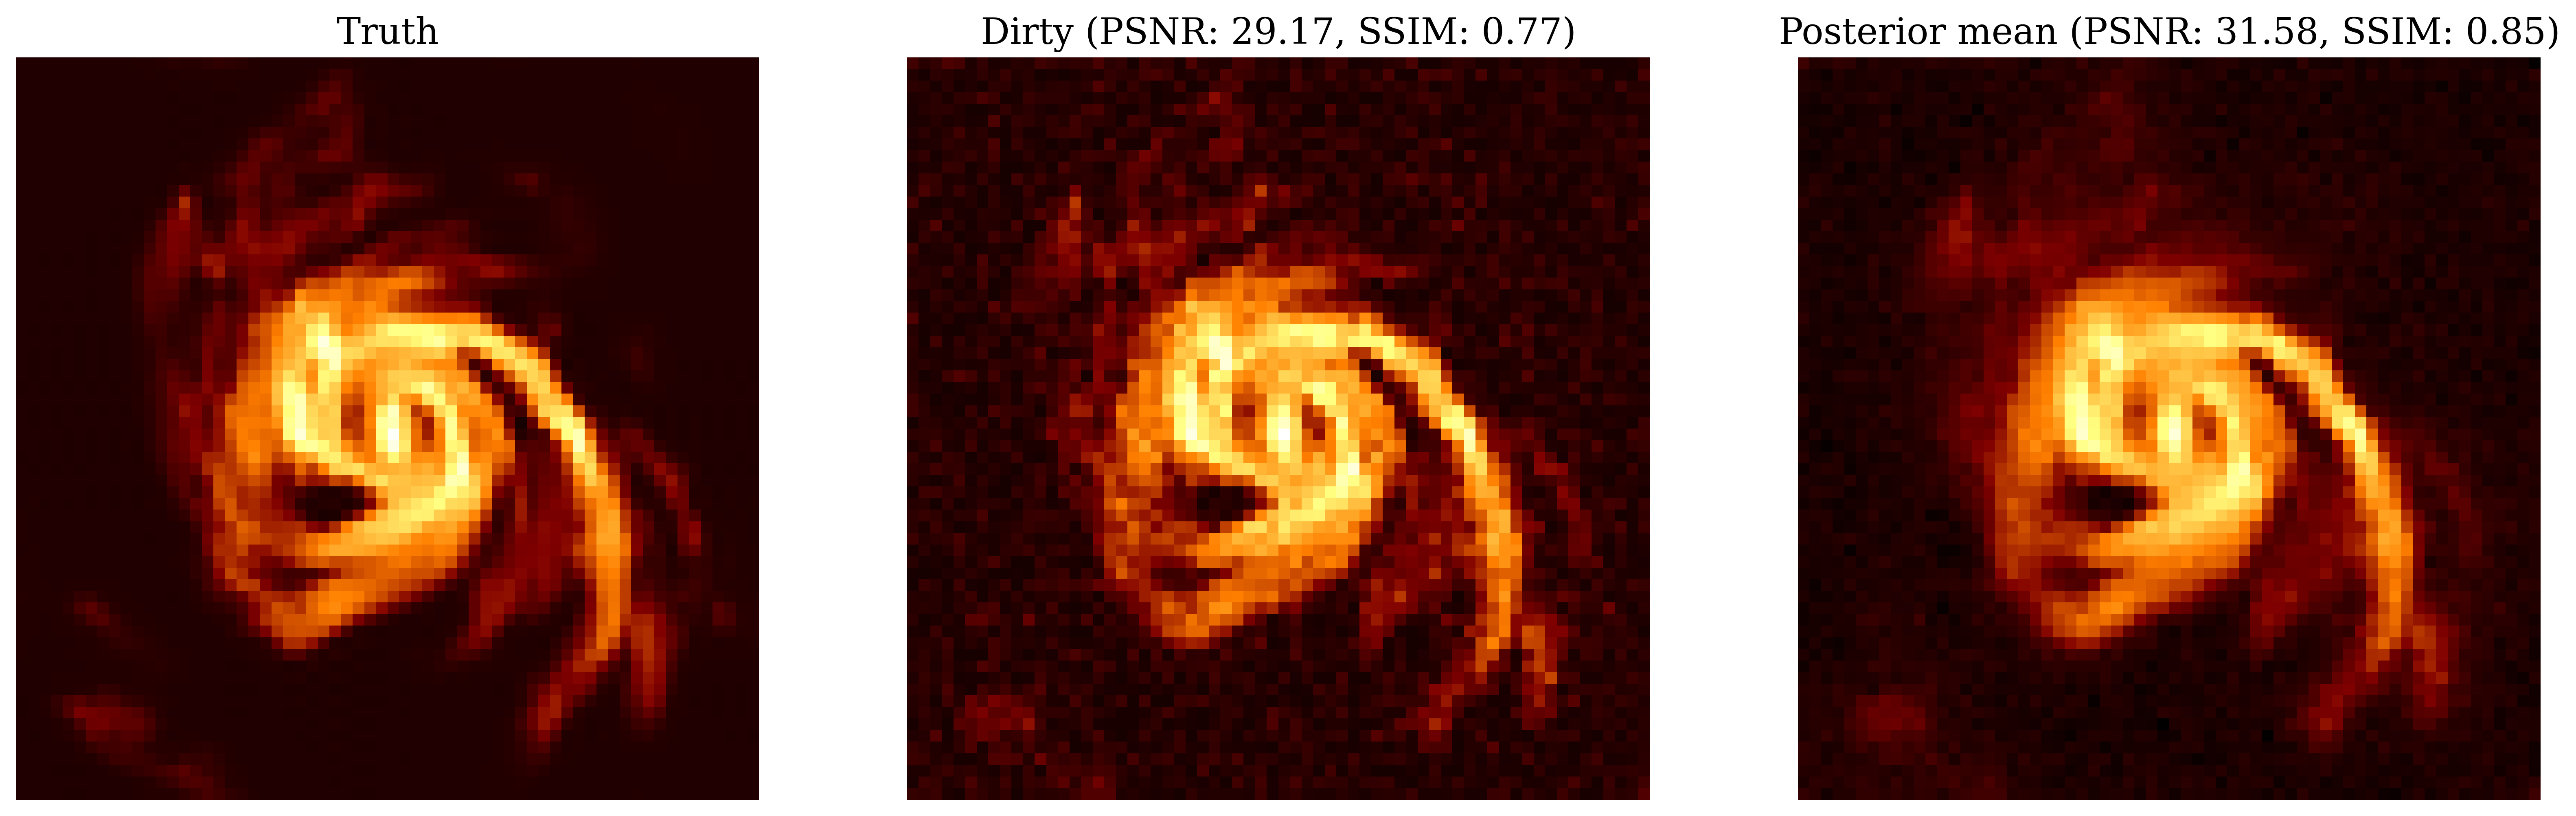

In [14]:
# DnCNN

images = [ground_truth, X0, NS_Trace_DnCNN['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

# plt.savefig('{:s}{:s}_reconstruction_plot.pdf'.format(save_fig_dir, save_prefix_DnCNN))
plt.show()

dirty_DnCNN_SNR = psnr(ground_truth, X0, data_range=ground_truth.max()-ground_truth.min())
post_mean_DnCNN_SNR = psnr(ground_truth, NS_Trace_DnCNN['DiscardPostMean'], data_range=ground_truth.max()-ground_truth.min())


In [15]:
save_dict_DnCNN = {
    'ground_truth': ground_truth,
    'X0': X0,
    'dirty_SNR': dirty_DnCNN_SNR,
    'post_mean_SNR': post_mean_DnCNN_SNR,
    'NS_BayEvi': NS_BayEvi_DnCNN,
    'NS_Trace': NS_Trace_DnCNN,
    'options': options_DnCNN,
}

try:
    np.save('{:s}{:s}_saved_vars.pdf'.format(save_var_dir, save_prefix_DnCNN), save_dict_DnCNN, allow_pickle=True)
except Exception as e:
    print('cannot save variables')
    print(e)


cannot save variables
[Errno 2] No such file or directory: '../paper_vars/denoising_DnCNN_delta_1.0e-07_lamb_5.0e-07_gamma_8.3e-06_saved_vars.pdf.npy'


# WAV model


In [16]:
time_start = time.time()
# Perform proximal nested sampling
NS_BayEvi_WAV, NS_Trace_WAV = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_WAV, proxB_WAV, params_WAV, options_WAV
)
elapsed_time = time.time() - time_start
print('elapsed_time: ', elapsed_time)

ProxNest || Initialise: 100%|██████████| 200/200 [00:00<00:00, 399.57it/s]
ProxNest || Populate: 100%|██████████| 2098/2098 [00:01<00:00, 1371.83it/s]
ProxNest || Sample: 100%|██████████| 2500/2500 [00:36<00:00, 68.92it/s]
ProxNest || Compute Weights: 100%|██████████| 2500/2500 [00:00<00:00, 589087.64it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 2498/2498 [00:00<00:00, 1171179.45it/s]
ProxNest || Estimate Variance: 100%|██████████| 2500/2500 [00:00<00:00, 280788.35it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 2500/2500 [00:00<00:00, 317452.09it/s]

elapsed_time:  38.35901498794556


In [17]:
print(NS_BayEvi_WAV)


[-2.58471662e+03  3.82742175e-01]


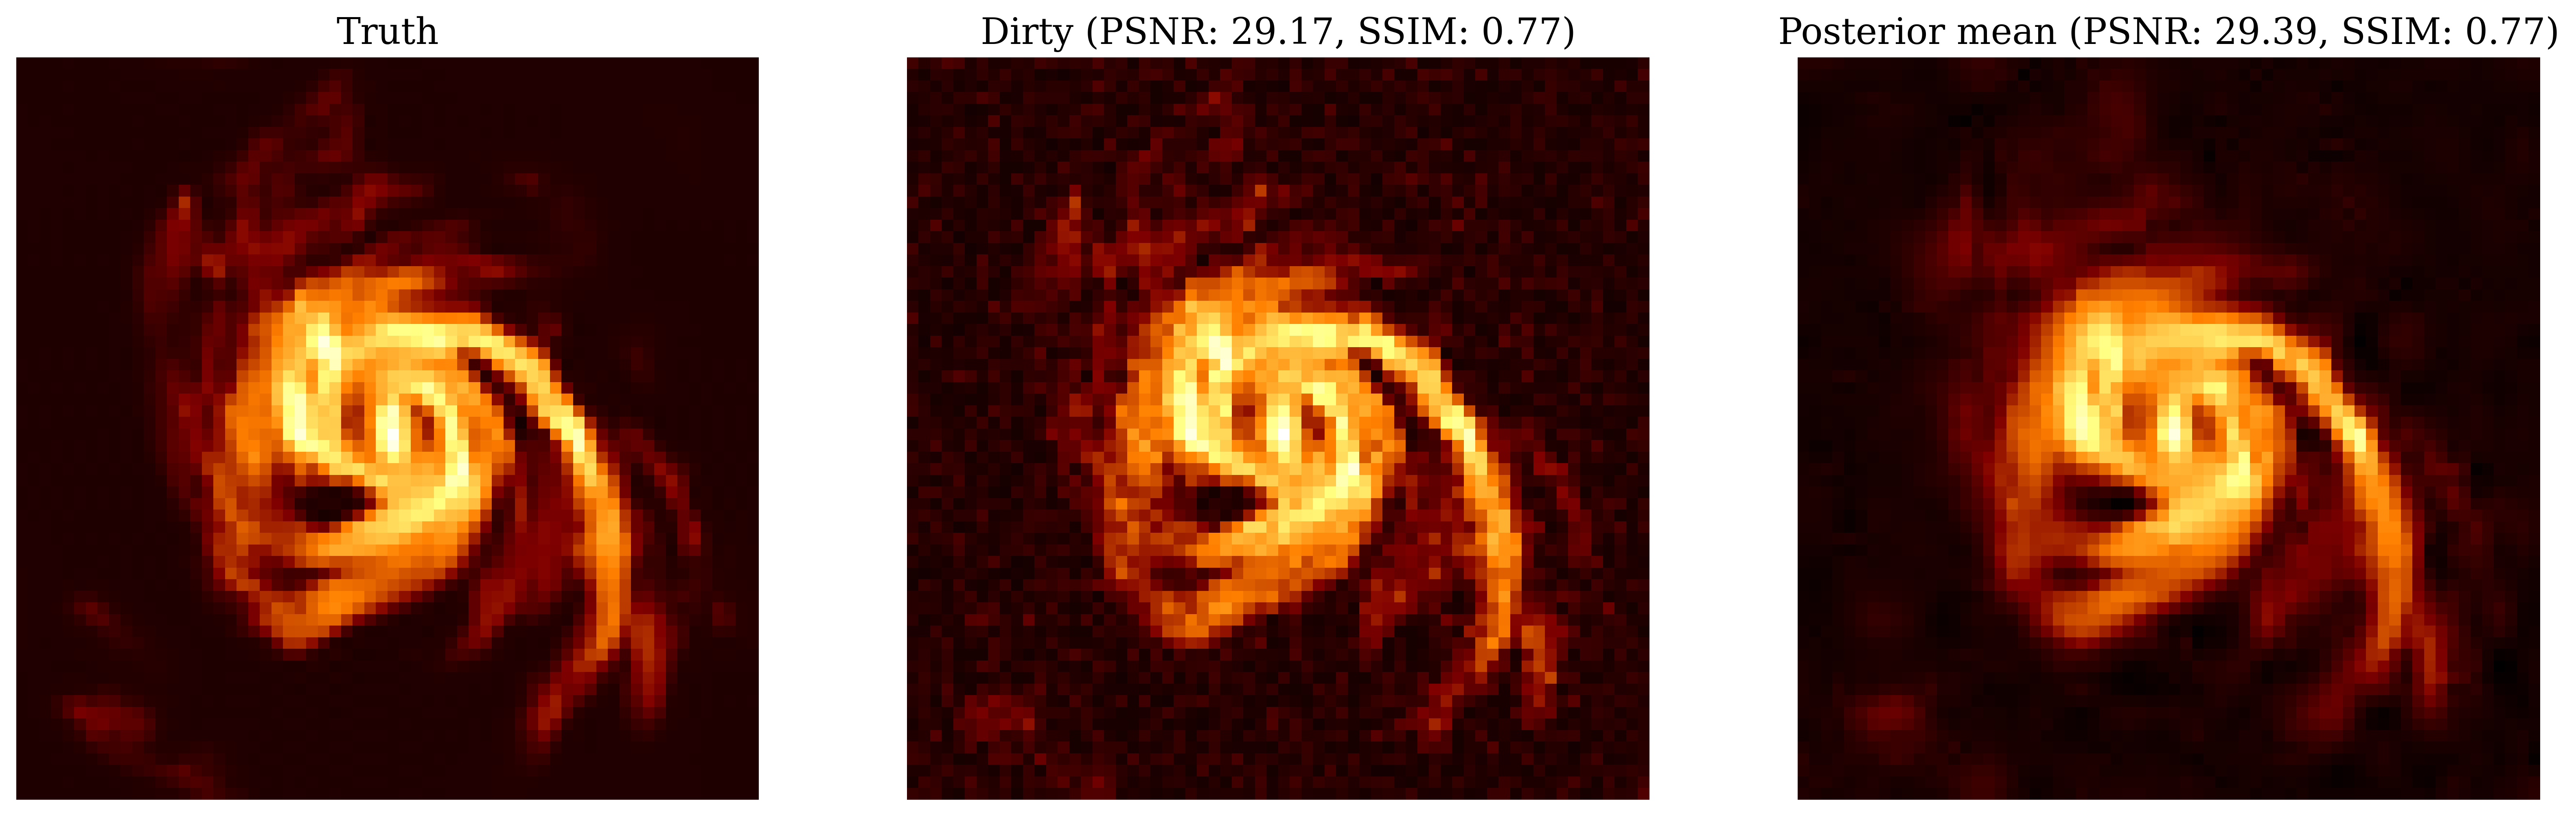

In [18]:
# WAV

images = [ground_truth, X0, NS_Trace_WAV['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')


# plt.savefig('{:s}{:s}_reconstruction_plot.pdf'.format(save_fig_dir, save_prefix_WAV))
plt.show()
# plt.close()

dirty_WAV_SNR = psnr(ground_truth, X0, data_range=ground_truth.max()-ground_truth.min())
post_mean_WAV_SNR = psnr(ground_truth, NS_Trace_WAV['DiscardPostMean'], data_range=ground_truth.max()-ground_truth.min())


In [19]:

save_dict_WAV = {
    'ground_truth': ground_truth,
    'X0': X0,
    'dirty_SNR': dirty_WAV_SNR,
    'post_mean_SNR': post_mean_WAV_SNR,
    'NS_BayEvi': NS_BayEvi_WAV,
    'NS_Trace': NS_Trace_WAV,
    'options': options_WAV,
}

try:
    np.save('{:s}{:s}_saved_vars.pdf'.format(save_var_dir, save_prefix_WAV), save_dict_WAV, allow_pickle=True)
except Exception as e:
    print('cannot save variables')
    print(e)




cannot save variables
[Errno 2] No such file or directory: '../paper_vars/denoising_WAV_delta_1.0e-07_lamb_5.0e-07_gamma_5.0e-07_saved_vars.pdf.npy'


## Print results

In [20]:


print('NS_BayEvi_DnCNN: ', NS_BayEvi_DnCNN)
print('NS_BayEvi_WAV: ', NS_BayEvi_WAV)

print('dirty_DnCNN_SNR: ', dirty_DnCNN_SNR)
print('post_mean_DnCNN_SNR: ', post_mean_DnCNN_SNR)

print('dirty_WAV_SNR: ', dirty_WAV_SNR)
print('post_mean_WAV_SNR: ', post_mean_WAV_SNR)


NS_BayEvi_DnCNN:  [-1.08379125e+03  3.56730146e-01]
NS_BayEvi_WAV:  [-2.58471662e+03  3.82742175e-01]
dirty_DnCNN_SNR:  29.172629597505257
post_mean_DnCNN_SNR:  31.57920173998034
dirty_WAV_SNR:  29.172629597505257
post_mean_WAV_SNR:  29.38738549151402


## Produce paper plots


In [21]:
cmap = 'cubehelix'
model_prefix = 'denoising'


FileNotFoundError: [Errno 2] No such file or directory: '../paper_figures/denoising-GroundTruth_image.pdf'

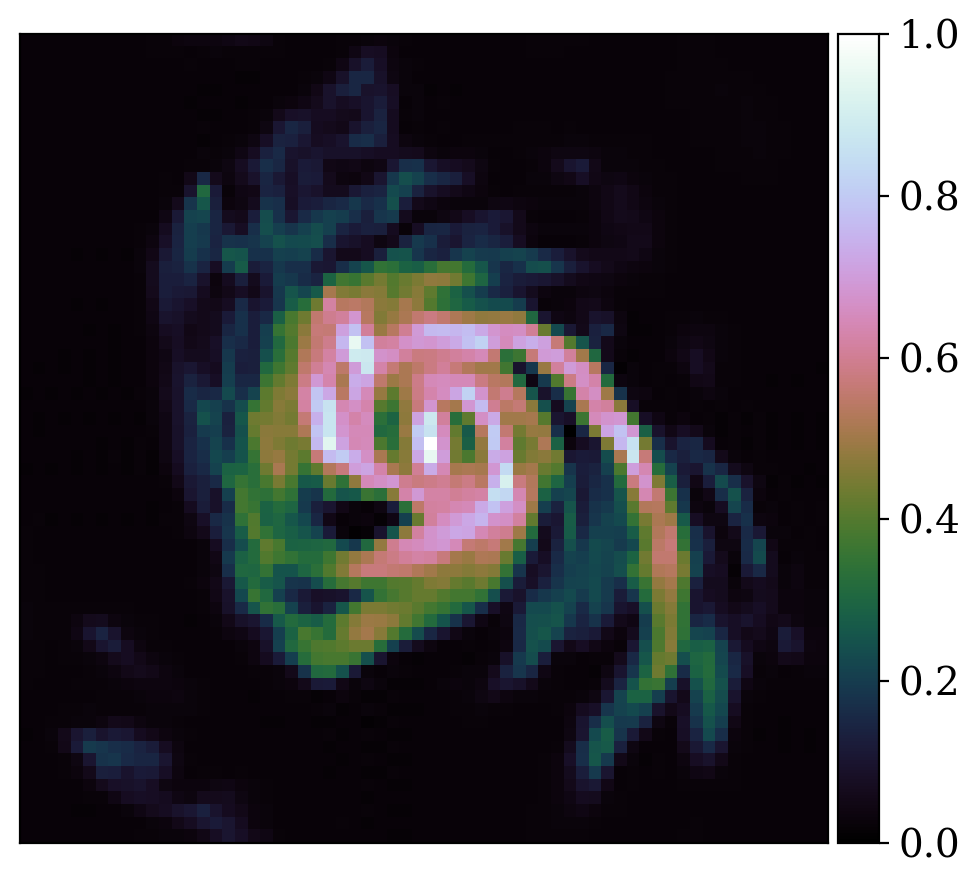

In [22]:
# Ground truth image
plot_img = ground_truth
snr_fontsize = 18
cbar_fontsize = 14

fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_fontsize)
axs.set_yticks([]);axs.set_xticks([])
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_fig_dir, model_prefix, '-GroundTruth_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()


# Dirty image
plot_img = X0

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_fontsize)
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=snr_fontsize, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_fig_dir, model_prefix, '-dirty_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()

## Posterior mean
plot_img = NS_Trace_DnCNN['DiscardPostMean']

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_fontsize)
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=snr_fontsize, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_fig_dir, model_prefix, '-DnCNN-posterior_mean_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()


## Posterior mean
plot_img = NS_Trace_WAV['DiscardPostMean']

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=cbar_fontsize)
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=snr_fontsize, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_fig_dir, model_prefix, '-WAV-posterior_mean_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()
